In [1]:
import os
import time
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load The Data

Using the NYU Depth Dataset V2, [available here](https://cs.nyu.edu/~fergus/datasets/nyu_depth_v2.html#raw_parts).

Data download steps:
1. Download the data (matlab file) from the link provided. I chose the 'labeled dataset', not the 'raw dataset'
2. Open the file in Matlab
3. Save all of the images individually in a new images folder, mine being data/images
4. Save all of the labels individually in a new labels folder, mine being data/labels
5. Save all of the depths individually in a new depths folder, mine being data/depth_images


In [2]:
class NYUDepthV2Dataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images_folder = os.path.join(root, 'images')
        self.labels_folder = os.path.join(root, 'labels')
        self.depths_folder = os.path.join(root, 'depth_images')
        self.image_filenames = sorted(os.listdir(self.images_folder))
        self.label_filenames = sorted(os.listdir(self.labels_folder))
        self.depths_filenames = sorted(os.listdir(self.depths_folder))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_folder, self.image_filenames[idx])
        label_path = os.path.join(self.labels_folder, self.label_filenames[idx])
        depth_path = os.path.join(self.depths_folder, self.depths_filenames[idx])

        # Load images using PIL
        image = Image.open(image_path).convert('RGB')
        label = Image.open(label_path).convert('L')
        depth = Image.open(depth_path).convert('L')

        if self.transform:
            image = self.transform['image'](image)
            label = self.transform['label'](label)
            depth = self.transform['depth'](depth)

        return image, label, depth


# Define separate transformations for images and labels/depths (labels and depths are heat maps)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

heat_map_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Combine transformations into a dictionary
transform = {'image': image_transform, 'label': heat_map_transform, 'depth': heat_map_transform}

dataset = NYUDepthV2Dataset(root='./data', transform=transform)

#### Displaying the Data

Note: a value of 0 for the label represents the data is unlabeled at that pixel

In [3]:
def undo_transform(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Undo the normalization done to images
    image_np = np.copy(image_tensor)
    for i in range(3):
        image_np[..., i] = (image_np[..., i] * std[i]) + mean[i]
    image_np = np.clip(image_np * 255, 0, 255).astype(np.uint8)
    return image_np

In [4]:
def print_images(image, label=None, predicted_label=None, depth=None, predicted_depth=None, model_name=None):
    # Prints an image and its correspondences

    # Determine how many images are being printed (image, label, generated label, depth, generated depth)
    variables = [image, label, predicted_label, depth, predicted_depth]
    count_images = sum(1 for var in variables if var is not None)
    num_rows = (2 if count_images > 3 else 1)
    image_index = 1

    # Display the image
    image_np = undo_transform(image.permute(1, 2, 0).numpy())
    plt.figure(figsize=(10, 5))
    plt.subplot(num_rows, 3, image_index)
    plt.imshow(image_np)
    plt.title('Image')
    plt.axis('off')
    image_index += 1

    if label is not None:
        # Display the label as a heatmap
        label_np = label.permute(1, 2, 0).numpy()
        plt.subplot(num_rows, 3, image_index)
        plt.imshow(label_np.squeeze(), cmap='jet')
        plt.title('Label (Label Map)')
        plt.axis('off')
        image_index += 1
    
    if predicted_label is not None:
        # Display the predicted label
        plt.subplot(num_rows, 3, image_index)
        if model_name is None:
            plt.title('Predicted Label')
        else:
            plt.title(f'Pred. Label for {model_name}')
        plt.imshow(predicted_label.squeeze(), cmap='jet')
        plt.axis('off')
        image_index += 1

    def format_ticks(x, pos):
        return f'{x * 100:.1f}'

    if depth is not None:
        # Display the depth as a heatmap
        depth_np = depth.permute(1, 2, 0).numpy()
        plt.subplot(num_rows, 3, image_index)
        plt.imshow(depth_np.squeeze(), cmap='jet')
        plt.title('Depth (Depth Map)')
        plt.axis('off')
        cbar = plt.colorbar(label='Depth (m)')
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
        image_index += 1

    if predicted_depth is not None:
        # Display the predicted depth
        plt.subplot(num_rows, 3, image_index)
        if model_name is None:
            plt.title('Predicted Depth')
        else:
            plt.title(f'Pred. Depth for {model_name}')
        plt.imshow(predicted_depth.squeeze(), cmap='jet')
        plt.axis('off')
        cbar = plt.colorbar(label='Depth (m)')
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
        image_index += 1
    
    plt.show()
    

Number of images in the dataset: 1449


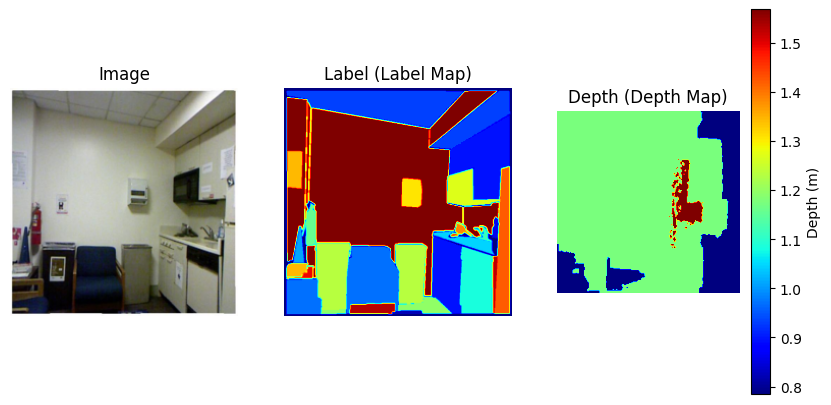

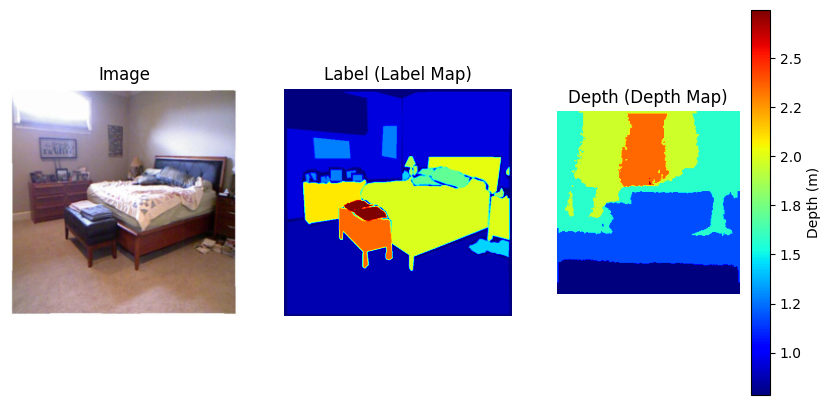

In [5]:
print(f'Number of images in the dataset: {len(dataset)}')
image, label, depth = dataset[0]
print_images(image, label=label, depth=depth)
image, label, depth = dataset[1448]
print_images(image, label=label, depth=depth)


## Model

Test-train split. Implemented a set seed for replicability

In [6]:
seed = 37       # Seed for reproducability
batch_size = 32
torch.manual_seed(seed)
np.random.seed(seed)

# Shuffle the indices of the dataset
indices = np.random.permutation(len(dataset))
shuffled_dataset = [dataset[i] for i in indices]

# Train, validation, test split
train_size = int(0.6 * len(dataset))  # 60% of the data for training
val_size = int(0.2 * len(dataset))    # 20% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining 20% for testing
train_set, val_set, test_set = random_split(shuffled_dataset, [train_size, val_size, test_size])

# Define data loaders for training, validation, and testing sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


#### Custom Loss Function

In the dataset, any label value of 0 indicates that the pixel is unlabeled. Defining a custom loss function to not penalize for the 0 values, but to disregard them.

In [7]:
class CustomWeightedLoss(nn.Module):
    def __init__(self, include_zero_loss=True):
        super(CustomWeightedLoss, self).__init__()
        self.include_zero_loss = include_zero_loss

    def forward(self, outputs, targets):
        # Compute the absolute difference between outputs and targets
        abs_diff = torch.abs(outputs - targets)

        if self.include_zero_loss:
            # Compute the total loss
            loss = torch.mean(abs_diff)
        else:
            # Compute the loss for non-zero elements
            mask = targets != 0
            masked_abs_diff = abs_diff[mask]
            loss = torch.mean(masked_abs_diff)

        return loss

In [8]:
class ModelRunner():
    def __init__(self, train_loader, val_loader, test_loader):
        # Input the data loaders
        self.save_dir = 'saved_models'
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.models = {}   

    def run_model_label(self, model, model_name, criterion=CustomWeightedLoss(include_zero_loss=False), optimizer=None, optimizer_learning_rate=0.001, num_epochs=10):
        self._run_model(model, model_name, True, criterion, optimizer, optimizer_learning_rate=optimizer_learning_rate, num_epochs=num_epochs)

    def run_model_depth(self, model, model_name, criterion=CustomWeightedLoss(include_zero_loss=True), optimizer=None, optimizer_learning_rate=0.001, num_epochs=10):
        self._run_model(model, model_name, False, criterion, optimizer, optimizer_learning_rate=optimizer_learning_rate, num_epochs=num_epochs)

    def _run_model(self, model, model_name, is_label, criterion, optimizer, optimizer_learning_rate, num_epochs):
        # Main function for running the neural net, either learning on the labels (as a heat map) or the depths

        # Input variable correction
        if optimizer is None:
            optimizer = optim.Adam(model.parameters(), lr=optimizer_learning_rate)
        if model is None or model_name is None:
            raise ValueError("Must pass in a model and model name")
        lowest_loss = float('inf')
        if model_name not in self.models:
            self.models[model_name] = {'label': None, 'depth': None}
        self.models[model_name][('label' if is_label else 'depth')] = {'model': model, 'lowest_loss': lowest_loss}

        # Run the neural network
        print(f'Starting training for {model_name}_{('Label' if is_label else 'Depth')}. Epochs: {num_epochs}. Learning rate: {optimizer_learning_rate}')
        for epoch in range(num_epochs):
            model.train()  
            running_loss = 0.0

            # Training
            for images, labels, depths in self.train_loader:
                optimizer.zero_grad()

                outputs = model(images)
                if is_label:
                    loss = criterion(outputs, labels)
                else:
                    loss = criterion(outputs, depths)

                # Backprop
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * images.size(0)
            epoch_loss = running_loss / len(train_set)

            # Epoch validation
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for images, labels, depths in self.val_loader:
                    outputs = model(images)
                    if is_label:
                        val_loss = criterion(outputs, labels)
                    else:
                        val_loss = criterion(outputs, depths)
                    running_val_loss += val_loss.item() * images.size(0)

            epoch_val_loss = running_val_loss / len(val_set)
            print(f'Epoch [{epoch+1}/{num_epochs}], \tTrain Loss: {epoch_loss:.5f}, \tValidation Loss: {epoch_val_loss:.5f}')

            # Save the model if it has a lower loss
            if epoch_val_loss < lowest_loss:
                lowest_loss = epoch_loss
                self.models[model_name][('label' if is_label else 'depth')] = {'lowest_loss': lowest_loss, 'model': model}

                # Delete the old models
                for filename in os.listdir(self.save_dir):
                    if filename.startswith(f'{model_name}_{(('Label' if is_label else 'Depth'))}_model_epoch_') and filename.endswith('.pth'):
                        epoch_num = int(filename.split('_')[-1].split('.')[0])
                        if epoch_num < epoch + 1:
                            os.remove(os.path.join(self.save_dir, filename))
                torch.save(model.state_dict(), os.path.join(self.save_dir, f'{model_name}_{(('Label' if is_label else 'Depth'))}_model_epoch_{epoch+1}.pth'))
    
    def load_model(self, model, model_name, is_label):
        # Load the model from a model file, used during testing
        latest_model_file = None
        latest_epoch = 0
        for filename in os.listdir(self.save_dir):
            if filename.startswith(f'{model_name}_{(('Label' if is_label else 'Depth'))}_model_epoch_') and filename.endswith('.pth'):
                epoch_num = int(filename.split('_')[-1].split('.')[0])
                if epoch_num > latest_epoch:
                    latest_epoch = epoch_num
                    latest_model_file = filename
        if latest_model_file:
            model.load_state_dict(torch.load(os.path.join(self.save_dir, latest_model_file)))
            print(f'Loaded model from {latest_model_file}')
        else:
            print('No saved model found for the specified model name.')

    def test_model_label(self, model, model_name, criterion=CustomWeightedLoss(include_zero_loss=False)):
        self._test_model(model, model_name, True, criterion)

    def test_model_depth(self, model, model_name, criterion=CustomWeightedLoss(include_zero_loss=True)):
        self._test_model(model, model_name, False, criterion)

    def _test_model(self, model, model_name, is_label, criterion):
        # Test the accuracy and speed of the model
        model.eval()
        start_time = time.time()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels, depths in test_loader:
                outputs = model(images)
                if is_label:
                    test_loss += criterion(outputs, labels).item() * images.size(0)
                else:
                    test_loss += criterion(outputs, depths).item() * images.size(0)
        end_time = time.time()

        test_loss /= len(test_set)
        self.models[model_name][('label' if is_label else 'depth')]['test_loss'] = test_loss
        test_time = (end_time - start_time) * 1000
        print(f'Val Loss: {self.models[model_name][('label' if is_label else 'depth')]['lowest_loss']}, \tTest Loss: {test_loss:.4f}, \tTest Time: {test_time: .0f}ms')     
        
    def showcase_label(self, model, model_name):
        self._showcase(model, model_name, True)

    def showcase_depth(self, model, model_name):
        self._showcase(model, model_name, False)

    def _showcase(self, model, model_name, is_label):
        # Show the generated images of the model

        model.eval()
        sample_images, sample_labels, sample_depths = next(iter(test_loader))
        with torch.no_grad():
            outputs = model(sample_images)

        # Show the first 5 images
        for i in range(5):
            if is_label:
                print_images(sample_images[i], label=sample_labels[i], predicted_label=outputs[i], depth=None, predicted_depth=None, model_name=model_name)
            else:
                print_images(sample_images[i], label=None, predicted_label=None, depth=sample_depths[i], predicted_depth=outputs[i], model_name=model_name)

model_runner = ModelRunner(train_loader, val_loader, test_loader)

### ResNet18

In [9]:
# Define ResNet18 CNN
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet = resnet18(pretrained=True)
        # Replace the final layer with a convolution layer
        self.conv1 = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.conv1(x)
        # Upsample the output tensor to the desired size
        x = nn.functional.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x

##### Depth Estimation

In [10]:
# Train the model
model_resnet18 = ResNet18()
model_runner.run_model_depth(model_resnet18, 'resnet18')

c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for resnet18_Depth. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.53929, 	Validation Loss: 5.39658
Epoch [2/10], 	Train Loss: 0.03297, 	Validation Loss: 0.09668
Epoch [3/10], 	Train Loss: 0.01970, 	Validation Loss: 0.01719
Epoch [4/10], 	Train Loss: 0.02006, 	Validation Loss: 0.00532
Epoch [5/10], 	Train Loss: 0.01964, 	Validation Loss: 0.01016
Epoch [6/10], 	Train Loss: 0.02289, 	Validation Loss: 0.12032
Epoch [7/10], 	Train Loss: 0.01717, 	Validation Loss: 0.46131
Epoch [8/10], 	Train Loss: 0.01904, 	Validation Loss: 0.00931
Epoch [9/10], 	Train Loss: 0.02528, 	Validation Loss: 0.00770
Epoch [10/10], 	Train Loss: 0.02846, 	Validation Loss: 0.13208


Val Loss: 0.025280327708712243, 	Test Loss: 0.0952, 	Test Time:  2566ms


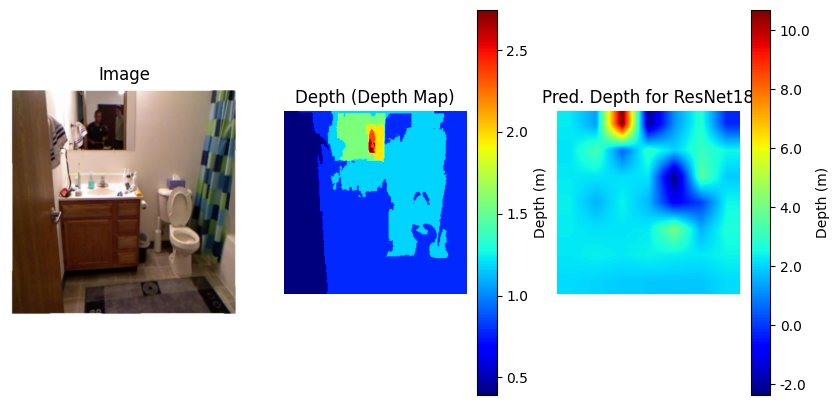

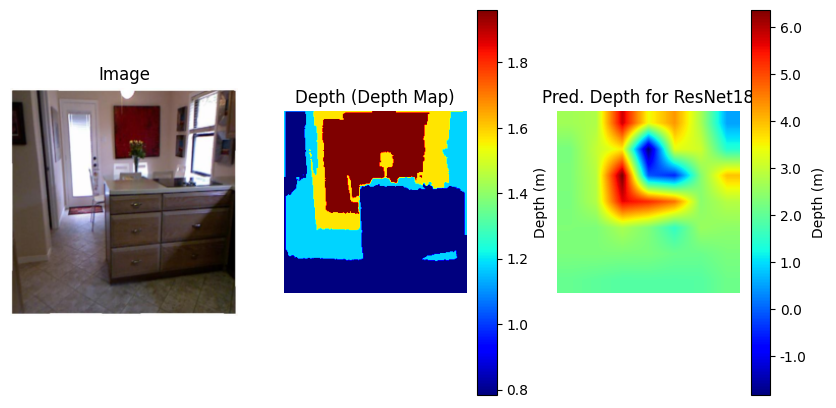

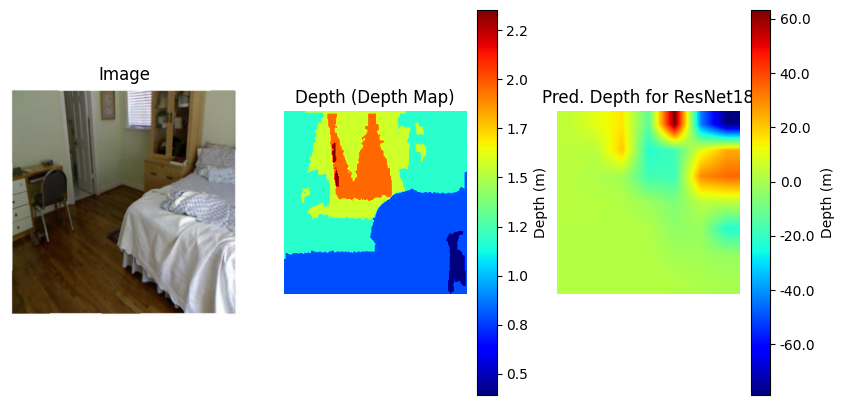

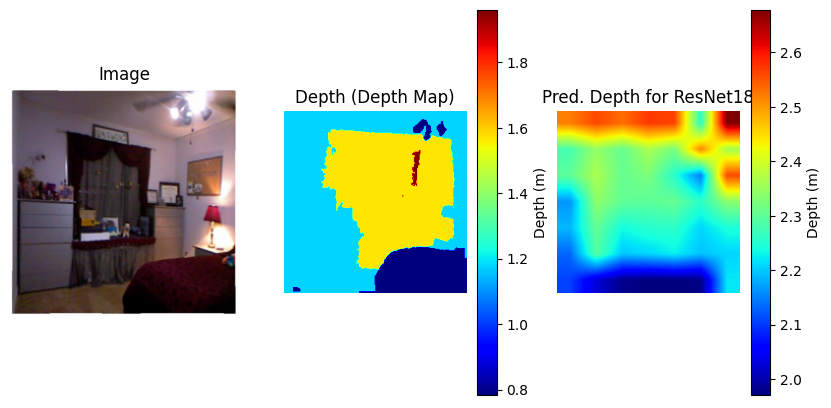

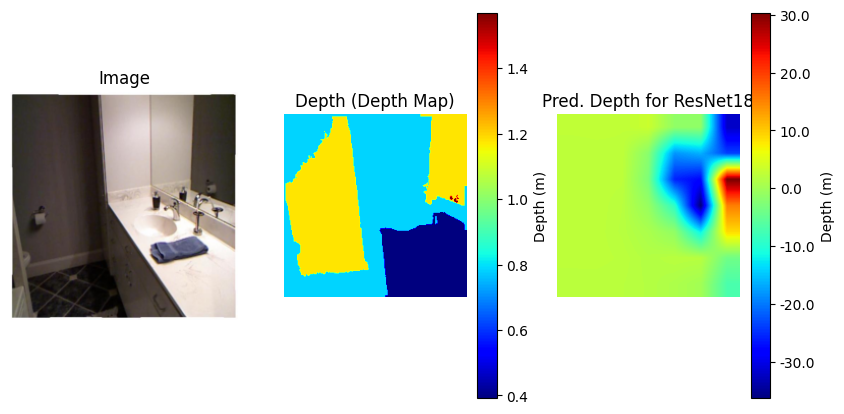

In [11]:
# Test the model
model_runner.test_model_depth(model_resnet18, 'resnet18')
model_runner.showcase_depth(model_resnet18, 'ResNet18')

##### Label Prediction

In [12]:
model_resnet18 = ResNet18()
model_runner.run_model_label(model_resnet18, 'resnet18')

c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for resnet18_Label. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.65964, 	Validation Loss: 7.17276
Epoch [2/10], 	Train Loss: 0.20228, 	Validation Loss: 0.32034
Epoch [3/10], 	Train Loss: 0.16969, 	Validation Loss: 0.19435
Epoch [4/10], 	Train Loss: 0.16249, 	Validation Loss: 0.16906
Epoch [5/10], 	Train Loss: 0.15798, 	Validation Loss: 0.17785
Epoch [6/10], 	Train Loss: 0.15662, 	Validation Loss: 0.42725
Epoch [7/10], 	Train Loss: 0.15201, 	Validation Loss: 0.18317
Epoch [8/10], 	Train Loss: 0.14489, 	Validation Loss: 0.14837
Epoch [9/10], 	Train Loss: 0.13795, 	Validation Loss: 0.14883
Epoch [10/10], 	Train Loss: 0.13432, 	Validation Loss: 0.21067


Val Loss: 0.14488724280487408, 	Test Loss: 0.1870, 	Test Time:  2544ms


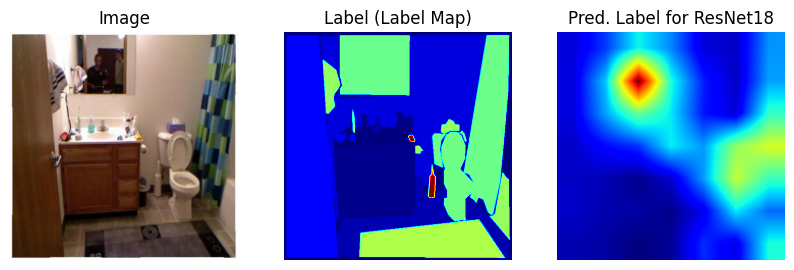

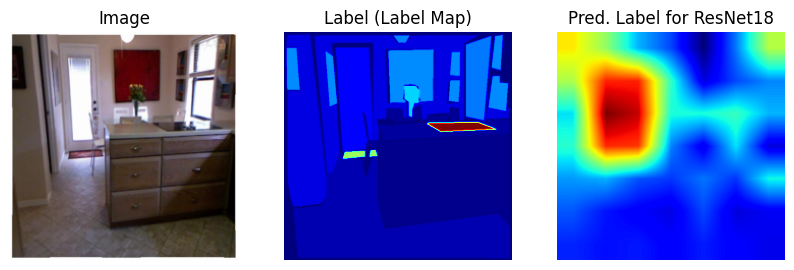

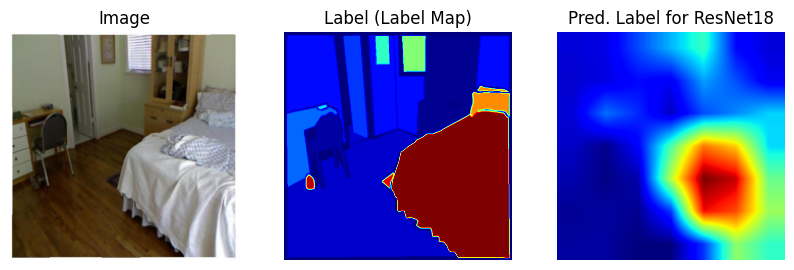

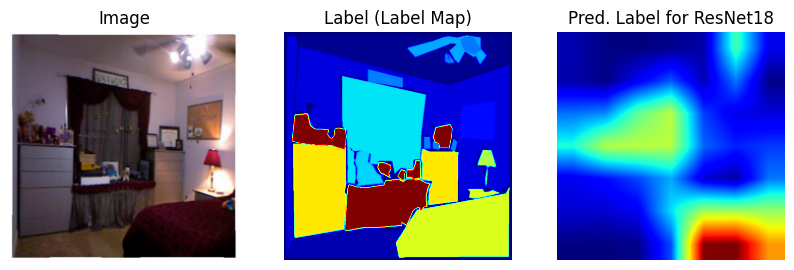

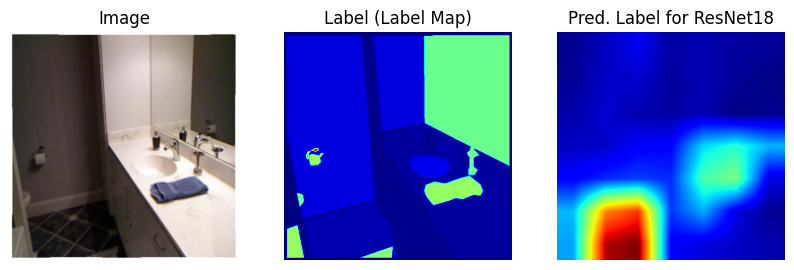

In [13]:
model_runner.test_model_label(model_resnet18, 'resnet18')
model_runner.showcase_label(model_resnet18, 'ResNet18')

### ResNet34

In [14]:
# Define ResNet34 CNN
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()
        self.resnet = resnet34(pretrained=True)
        self.conv1 = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.conv1(x)
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x


##### Depth Estimation

In [15]:
model_resnet34 = ResNet34()
model_runner.run_model_depth(model_resnet34, 'resnet34')

c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for resnet34_Depth. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.52497, 	Validation Loss: 12.86345
Epoch [2/10], 	Train Loss: 0.03344, 	Validation Loss: 0.04318
Epoch [3/10], 	Train Loss: 0.02898, 	Validation Loss: 0.02212
Epoch [4/10], 	Train Loss: 0.02366, 	Validation Loss: 0.13442
Epoch [5/10], 	Train Loss: 0.01850, 	Validation Loss: 0.01769
Epoch [6/10], 	Train Loss: 0.01815, 	Validation Loss: 0.94300
Epoch [7/10], 	Train Loss: 0.02082, 	Validation Loss: 0.00424
Epoch [8/10], 	Train Loss: 0.01616, 	Validation Loss: 0.02789
Epoch [9/10], 	Train Loss: 0.01281, 	Validation Loss: 0.00516
Epoch [10/10], 	Train Loss: 0.01929, 	Validation Loss: 0.14360


Val Loss: 0.012810001394125206, 	Test Loss: 0.1817, 	Test Time:  4371ms


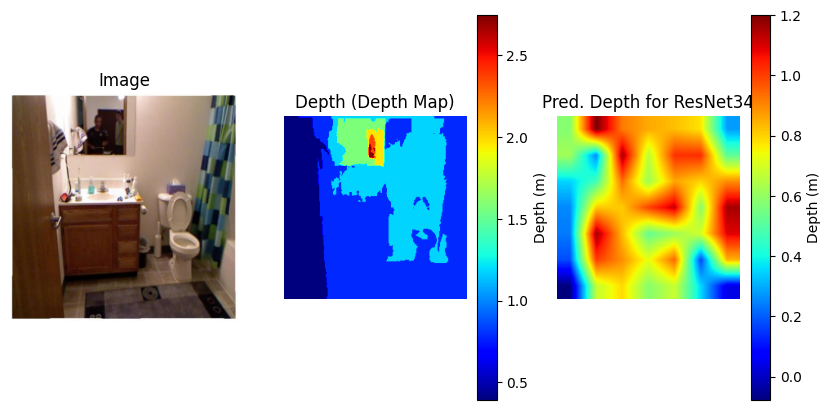

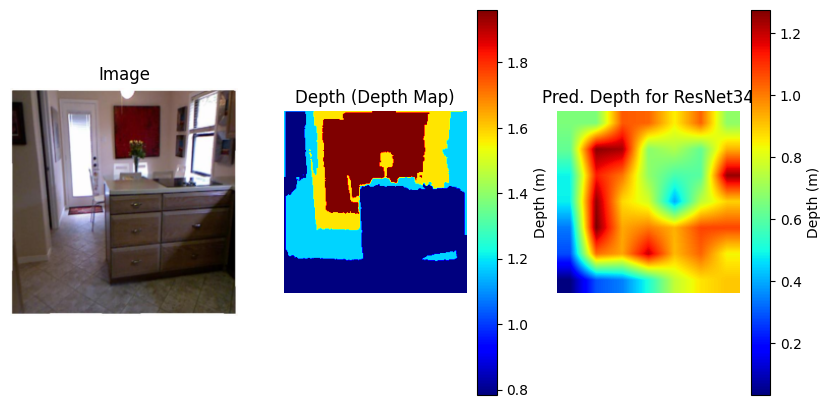

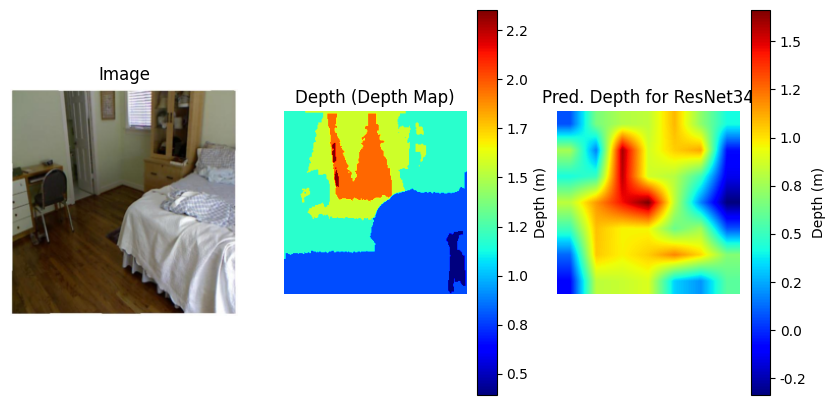

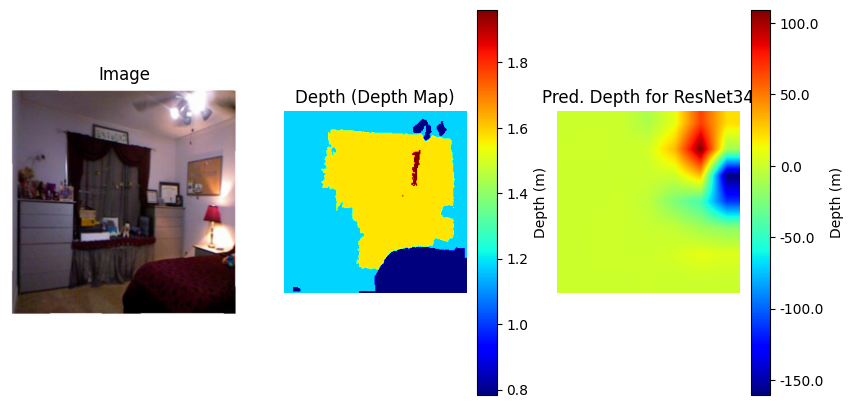

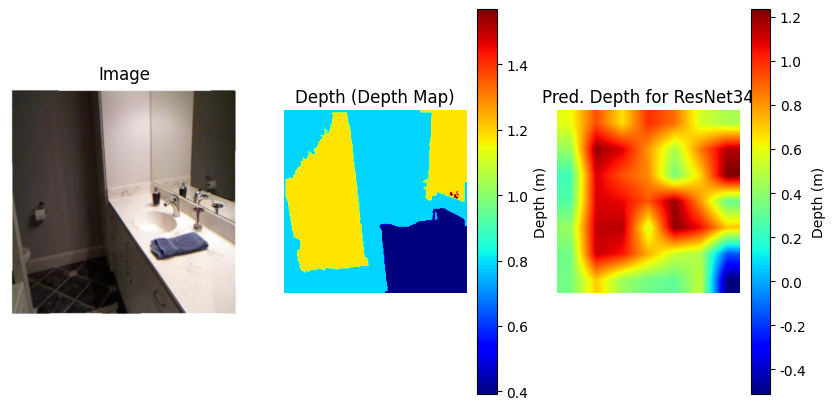

In [16]:
model_runner.test_model_depth(model_resnet34, 'resnet34')
model_runner.showcase_depth(model_resnet34, 'ResNet34')

##### Label Prediction

In [17]:
model_resnet34 = ResNet34()
model_runner.run_model_label(model_resnet34, 'resnet34')

Starting training for resnet34_Label. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.59079, 	Validation Loss: 0.17128
Epoch [2/10], 	Train Loss: 0.18155, 	Validation Loss: 0.24288
Epoch [3/10], 	Train Loss: 0.16878, 	Validation Loss: 0.19254
Epoch [4/10], 	Train Loss: 0.16688, 	Validation Loss: 0.17938
Epoch [5/10], 	Train Loss: 0.15472, 	Validation Loss: 0.15367
Epoch [6/10], 	Train Loss: 0.14917, 	Validation Loss: 0.58406
Epoch [7/10], 	Train Loss: 0.15960, 	Validation Loss: 0.15563
Epoch [8/10], 	Train Loss: 0.15675, 	Validation Loss: 1.27134
Epoch [9/10], 	Train Loss: 0.15510, 	Validation Loss: 0.23539
Epoch [10/10], 	Train Loss: 0.15589, 	Validation Loss: 0.18863


Val Loss: 0.15472141883932955, 	Test Loss: 0.1938, 	Test Time:  4344ms


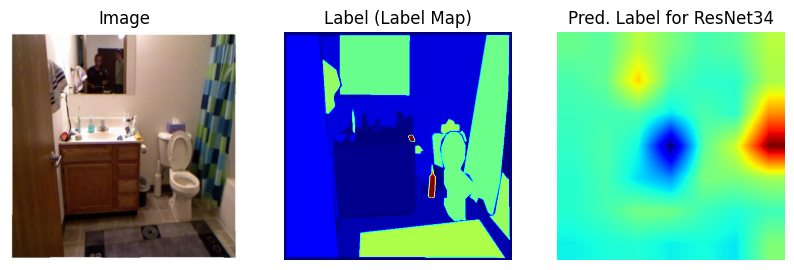

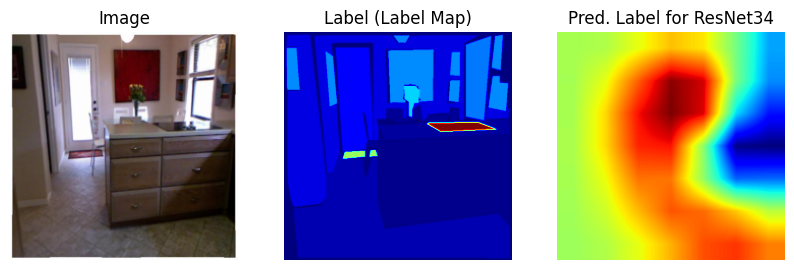

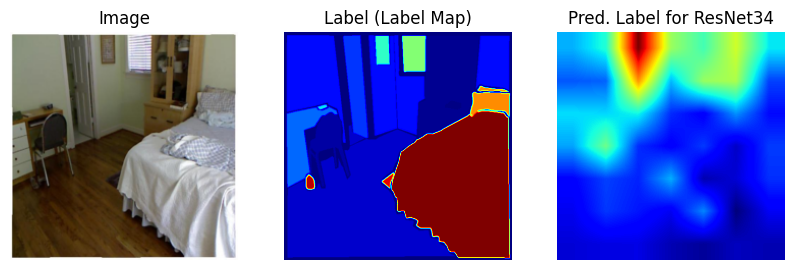

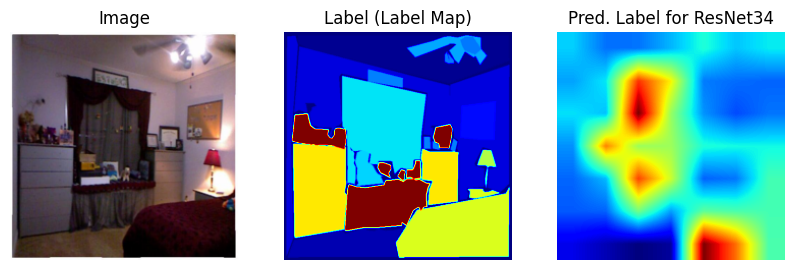

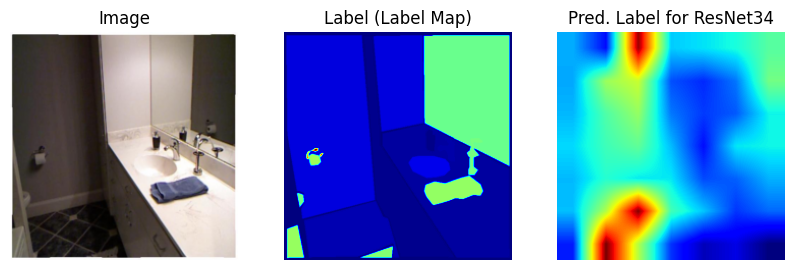

In [18]:
model_runner.test_model_label(model_resnet34, 'resnet34')
model_runner.showcase_label(model_resnet34, 'ResNet34')

### ResNet50

In [19]:
# Define ResNet50 CNN
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.conv1 = nn.Conv2d(2048, 1, kernel_size=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.conv1(x)
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x


##### Depth Estimation

In [20]:
model_resnet50 = ResNet50()
model_runner.run_model_depth(model_resnet50, 'resnet50')

c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for resnet50_Depth. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.25418, 	Validation Loss: 8.78872
Epoch [2/10], 	Train Loss: 0.02801, 	Validation Loss: 0.14841
Epoch [3/10], 	Train Loss: 0.01739, 	Validation Loss: 0.13101
Epoch [4/10], 	Train Loss: 0.01293, 	Validation Loss: 0.12358
Epoch [5/10], 	Train Loss: 0.01342, 	Validation Loss: 0.00562
Epoch [6/10], 	Train Loss: 0.01445, 	Validation Loss: 0.01407
Epoch [7/10], 	Train Loss: 0.01685, 	Validation Loss: 76.57626
Epoch [8/10], 	Train Loss: 0.02058, 	Validation Loss: 0.01482
Epoch [9/10], 	Train Loss: 0.02558, 	Validation Loss: 0.42650
Epoch [10/10], 	Train Loss: 0.02939, 	Validation Loss: 0.00434


Val Loss: 0.02938683373452742, 	Test Loss: 0.0042, 	Test Time:  6339ms


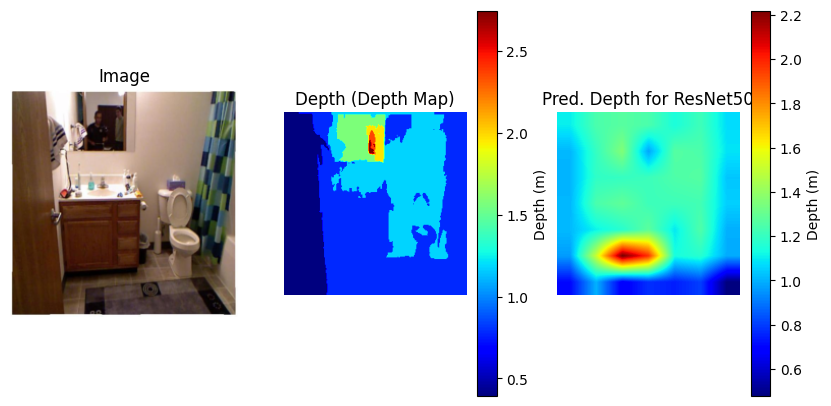

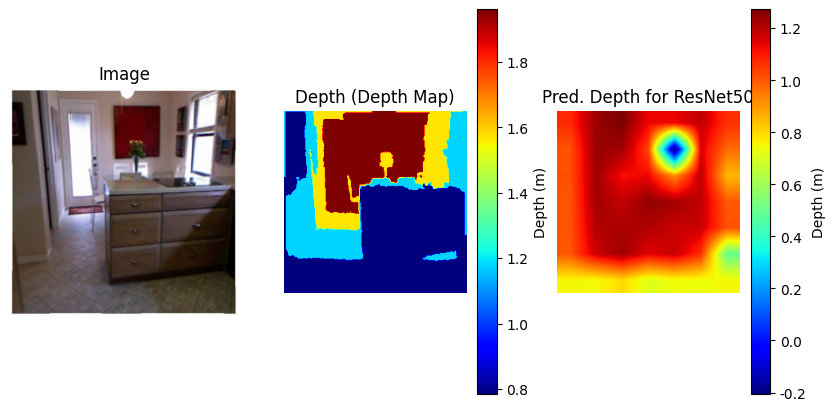

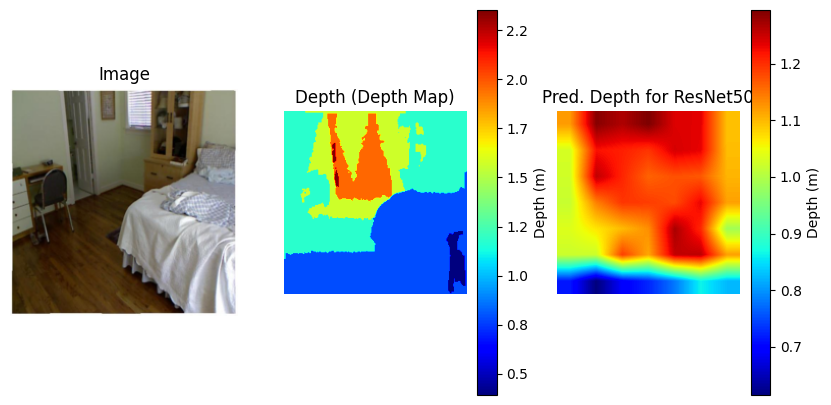

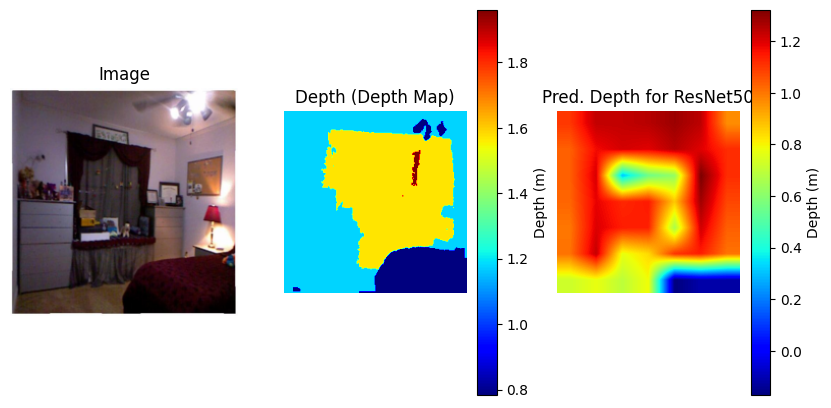

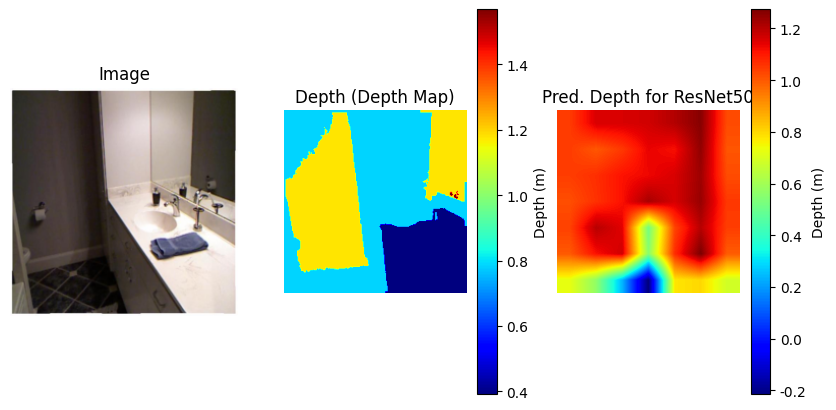

In [21]:
model_runner.test_model_depth(model_resnet50, 'resnet50')
model_runner.showcase_depth(model_resnet50, 'ResNet50')

##### Label Prediction

In [22]:
model_resnet50 = ResNet50()
model_runner.run_model_label(model_resnet50, 'resnet50')

Starting training for resnet50_Label. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.38840, 	Validation Loss: 1.47782
Epoch [2/10], 	Train Loss: 0.16420, 	Validation Loss: 0.28146
Epoch [3/10], 	Train Loss: 0.17067, 	Validation Loss: 0.15476
Epoch [4/10], 	Train Loss: 0.16892, 	Validation Loss: 0.16940
Epoch [5/10], 	Train Loss: 0.15086, 	Validation Loss: 0.21498
Epoch [6/10], 	Train Loss: 0.14789, 	Validation Loss: 0.16962
Epoch [7/10], 	Train Loss: 0.13867, 	Validation Loss: 0.14692
Epoch [8/10], 	Train Loss: 0.13871, 	Validation Loss: 0.14578
Epoch [9/10], 	Train Loss: 0.13634, 	Validation Loss: 0.19103
Epoch [10/10], 	Train Loss: 0.12942, 	Validation Loss: 0.24865


Val Loss: 0.13867029220174454, 	Test Loss: 0.2589, 	Test Time:  6440ms


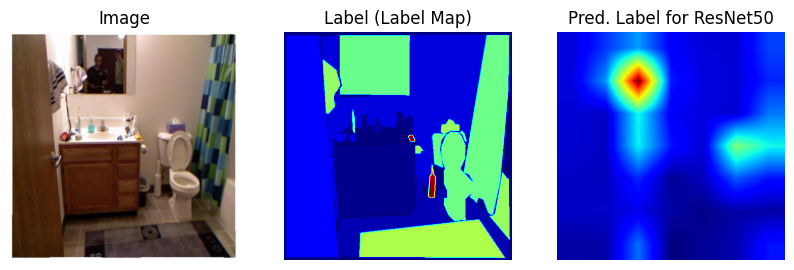

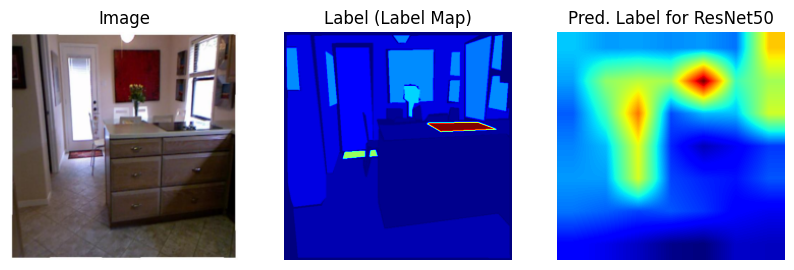

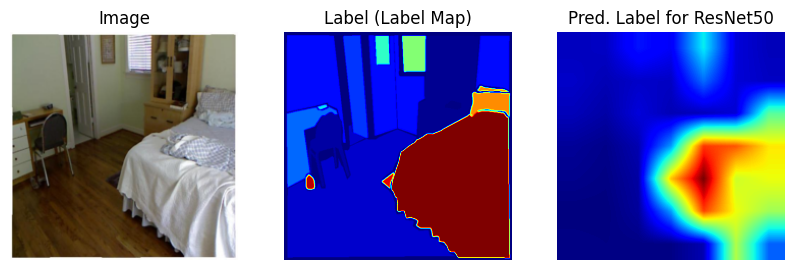

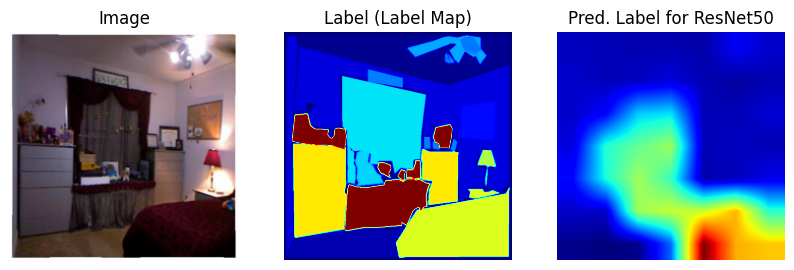

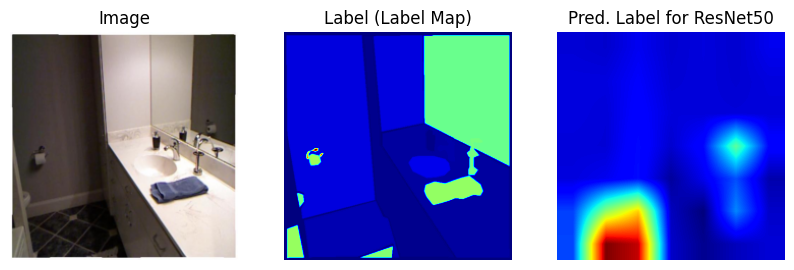

In [23]:
model_runner.test_model_label(model_resnet50, 'resnet50')
model_runner.showcase_label(model_resnet50, 'ResNet50')

### ResNet101

In [24]:
# Define ResNet101 CNN
class ResNet101(nn.Module):
    def __init__(self):
        super(ResNet101, self).__init__()
        self.resnet = resnet101(pretrained=True)
        self.conv1 = nn.Conv2d(2048, 1, kernel_size=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.conv1(x)
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x


##### Depth Estimation

In [25]:
model_resnet101 = ResNet101()
model_runner.run_model_depth(model_resnet101, 'resnet101')

c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for resnet101_Depth. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.29831, 	Validation Loss: 189.31341
Epoch [2/10], 	Train Loss: 0.02310, 	Validation Loss: 0.01430
Epoch [3/10], 	Train Loss: 0.01111, 	Validation Loss: 0.00912
Epoch [4/10], 	Train Loss: 0.01346, 	Validation Loss: 0.03785
Epoch [5/10], 	Train Loss: 0.02126, 	Validation Loss: 0.00497
Epoch [6/10], 	Train Loss: 0.03111, 	Validation Loss: 3.69202
Epoch [7/10], 	Train Loss: 0.02537, 	Validation Loss: 0.27683
Epoch [8/10], 	Train Loss: 0.01969, 	Validation Loss: 0.00750
Epoch [9/10], 	Train Loss: 0.01260, 	Validation Loss: 0.01189
Epoch [10/10], 	Train Loss: 0.01323, 	Validation Loss: 0.01114


Val Loss: 0.013225420441379893, 	Test Loss: 0.0094, 	Test Time:  11064ms


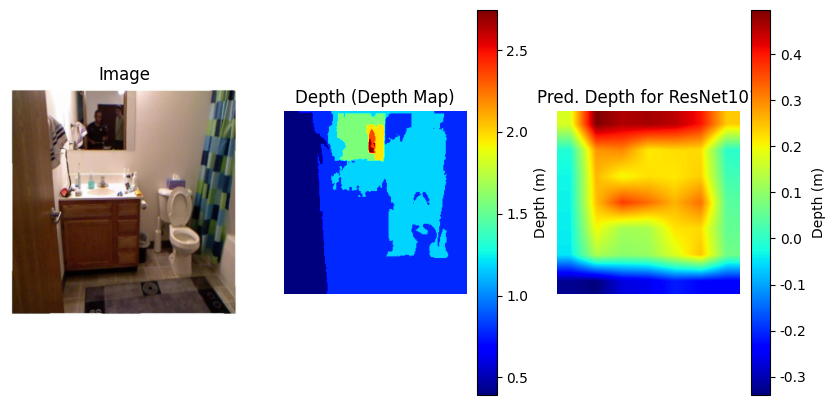

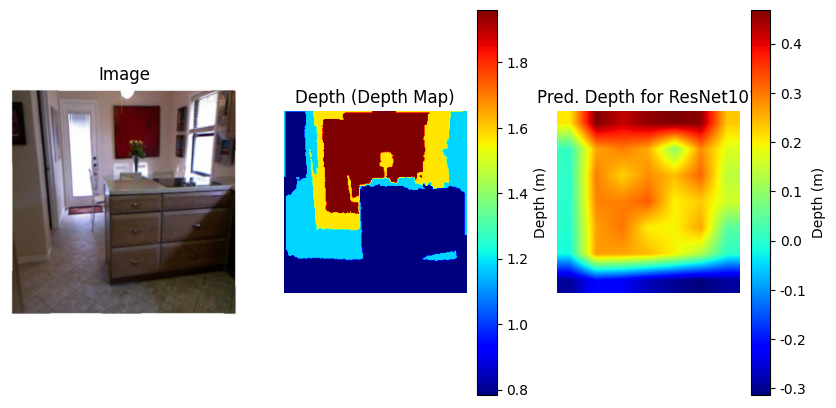

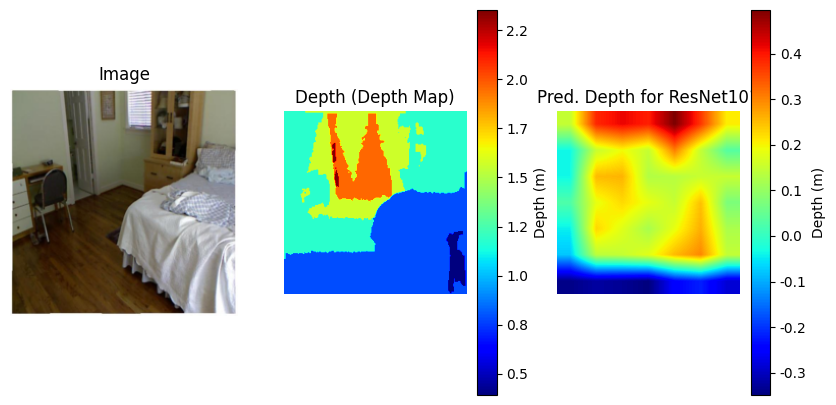

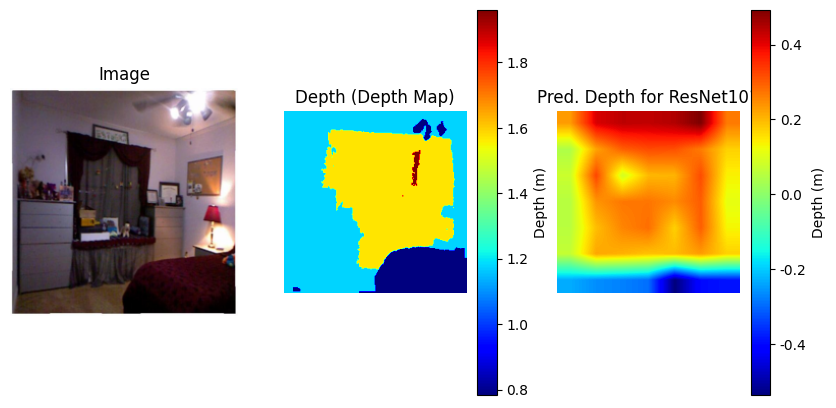

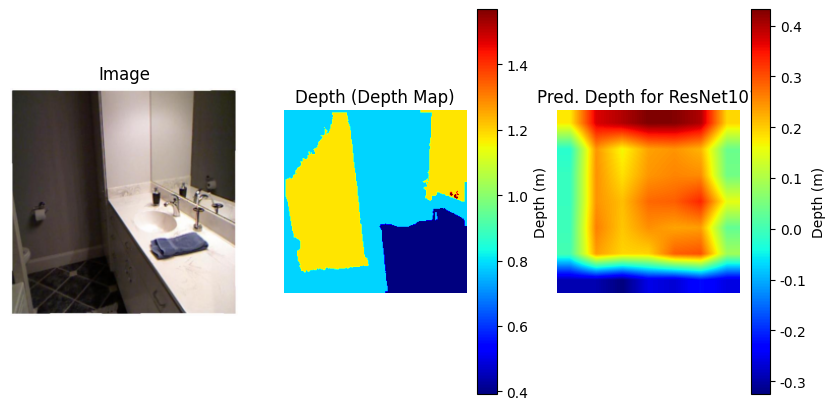

In [26]:
model_runner.test_model_depth(model_resnet101, 'resnet101')
model_runner.showcase_depth(model_resnet101, 'ResNet101')

##### Label Prediction

In [27]:
model_resnet101 = ResNet101()
model_runner.run_model_label(model_resnet101, 'resnet101')

Starting training for resnet101_Label. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.41771, 	Validation Loss: 0.56389
Epoch [2/10], 	Train Loss: 0.16634, 	Validation Loss: 0.16422
Epoch [3/10], 	Train Loss: 0.16488, 	Validation Loss: 0.45642
Epoch [4/10], 	Train Loss: 0.15960, 	Validation Loss: 0.17933
Epoch [5/10], 	Train Loss: 0.15975, 	Validation Loss: 0.16909
Epoch [6/10], 	Train Loss: 0.15991, 	Validation Loss: 0.32574
Epoch [7/10], 	Train Loss: 0.16277, 	Validation Loss: 0.27876
Epoch [8/10], 	Train Loss: 0.15979, 	Validation Loss: 3.15081
Epoch [9/10], 	Train Loss: 0.16354, 	Validation Loss: 3.00016
Epoch [10/10], 	Train Loss: 0.16284, 	Validation Loss: 0.15904


Val Loss: 0.16284036883276268, 	Test Loss: 0.1484, 	Test Time:  11354ms


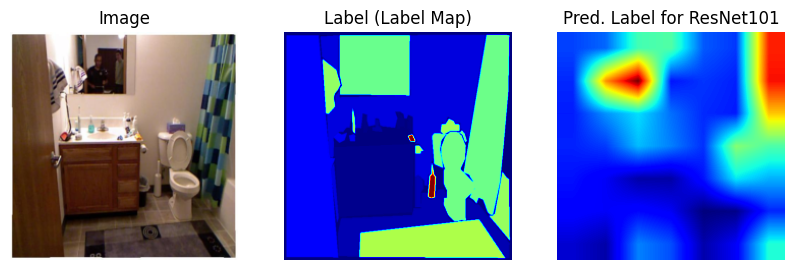

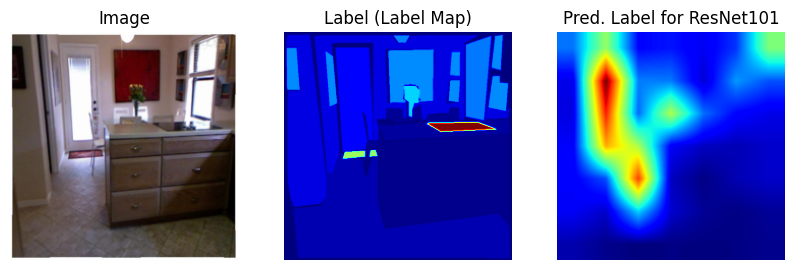

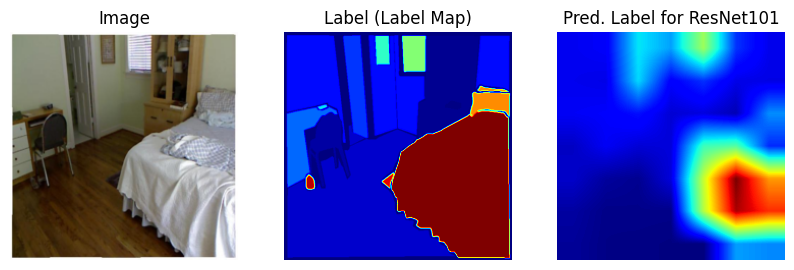

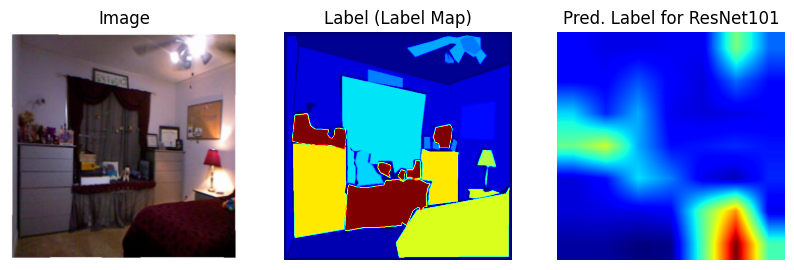

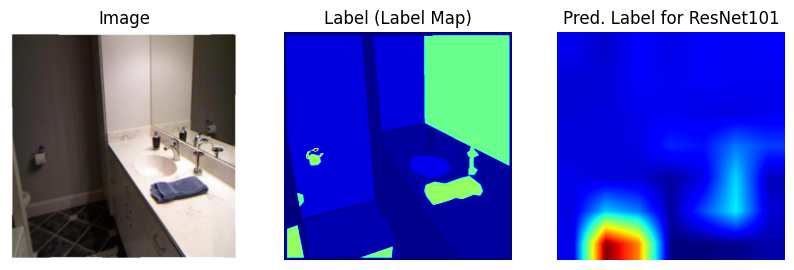

In [28]:
model_runner.test_model_label(model_resnet101, 'resnet101')
model_runner.showcase_label(model_resnet101, 'ResNet101')

### ResNet152

In [29]:
# Define ResNet152 CNN
class ResNet152(nn.Module):
    def __init__(self):
        super(ResNet152, self).__init__()
        self.resnet = resnet152(pretrained=True)
        self.conv1 = nn.Conv2d(2048, 1, kernel_size=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.conv1(x)
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=False)
        return x


##### Depth Estimation

In [30]:
model_resnet152 = ResNet152()
model_runner.run_model_depth(model_resnet152, 'resnet152')

c:\Users\jetts\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for resnet152_Depth. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.17034, 	Validation Loss: 128.15736
Epoch [2/10], 	Train Loss: 0.03059, 	Validation Loss: 35.07990
Epoch [3/10], 	Train Loss: 0.01734, 	Validation Loss: 44.65827
Epoch [4/10], 	Train Loss: 0.02210, 	Validation Loss: 2.07683
Epoch [5/10], 	Train Loss: 0.01422, 	Validation Loss: 0.01168
Epoch [6/10], 	Train Loss: 0.02697, 	Validation Loss: 2.20117
Epoch [7/10], 	Train Loss: 0.02271, 	Validation Loss: 0.01493
Epoch [8/10], 	Train Loss: 0.01803, 	Validation Loss: 0.12785
Epoch [9/10], 	Train Loss: 0.01274, 	Validation Loss: 0.02277
Epoch [10/10], 	Train Loss: 0.01151, 	Validation Loss: 0.19410


Val Loss: 0.01422452770593663, 	Test Loss: 0.1905, 	Test Time:  15785ms


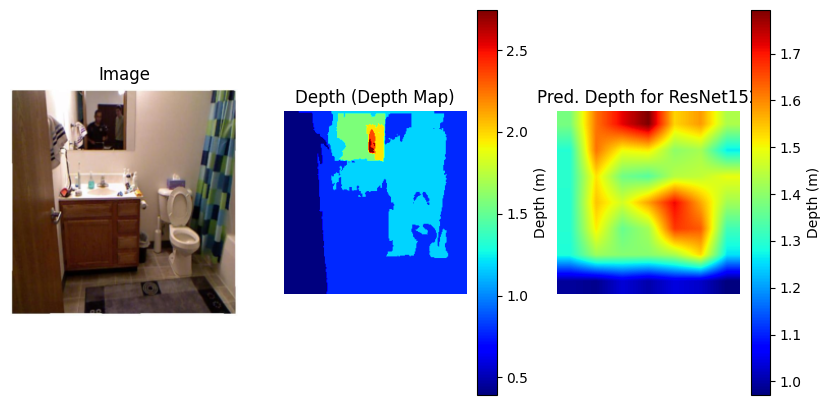

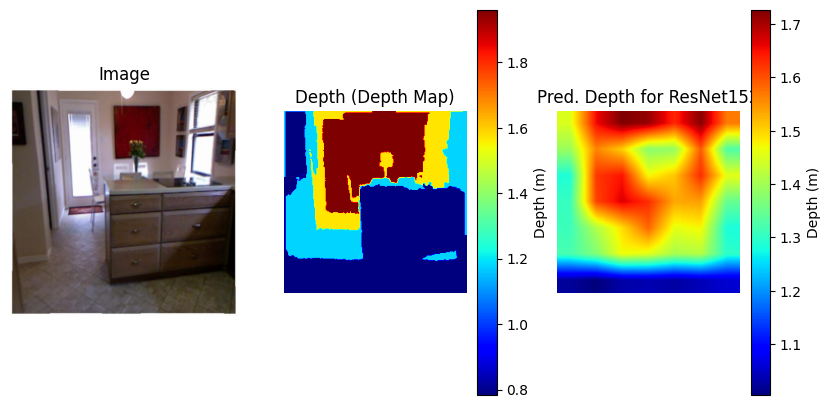

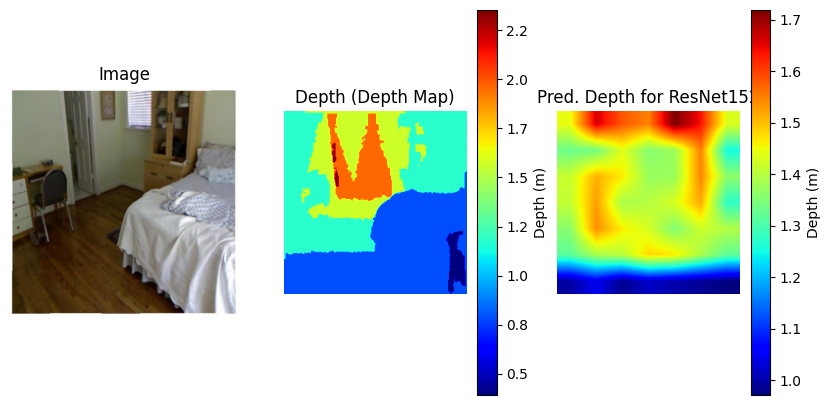

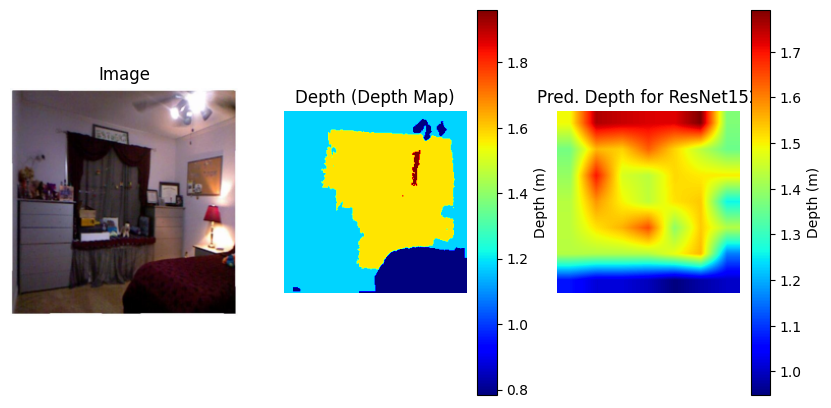

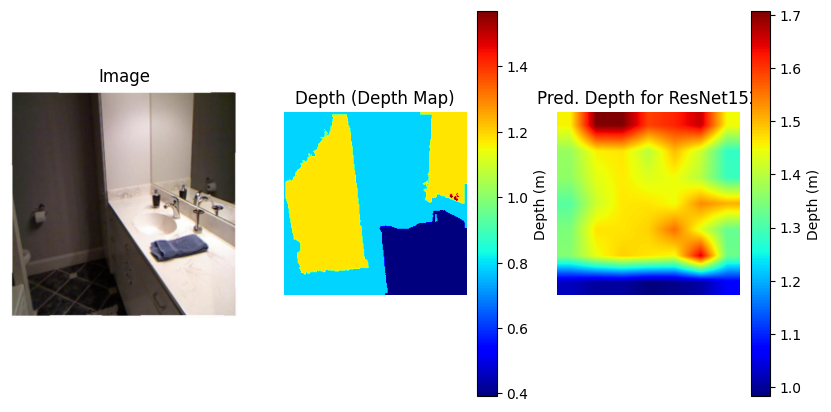

In [31]:
model_runner.test_model_depth(model_resnet152, 'resnet152')
model_runner.showcase_depth(model_resnet152, 'ResNet152')

##### Label Prediction

In [32]:
model_resnet152 = ResNet152()
model_runner.run_model_label(model_resnet152, 'resnet152')

Starting training for resnet152_Label. Epochs: 10. Learning rate: 0.001
Epoch [1/10], 	Train Loss: 0.50397, 	Validation Loss: 1039.91404
Epoch [2/10], 	Train Loss: 0.16879, 	Validation Loss: 5.54813
Epoch [3/10], 	Train Loss: 0.16286, 	Validation Loss: 0.94253
Epoch [4/10], 	Train Loss: 0.16368, 	Validation Loss: 0.31683
Epoch [5/10], 	Train Loss: 0.15193, 	Validation Loss: 0.15414
Epoch [6/10], 	Train Loss: 0.14781, 	Validation Loss: 0.15148
Epoch [7/10], 	Train Loss: 0.14393, 	Validation Loss: 0.31653
Epoch [8/10], 	Train Loss: 0.14252, 	Validation Loss: 0.14892
Epoch [9/10], 	Train Loss: 0.13730, 	Validation Loss: 0.81763
Epoch [10/10], 	Train Loss: 0.13789, 	Validation Loss: 0.14804


Val Loss: 0.1478077327303151, 	Test Loss: 0.1374, 	Test Time:  15074ms


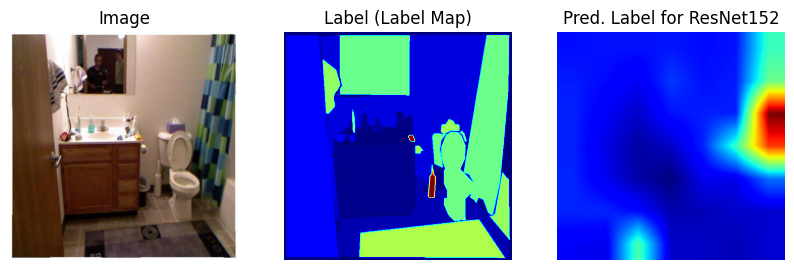

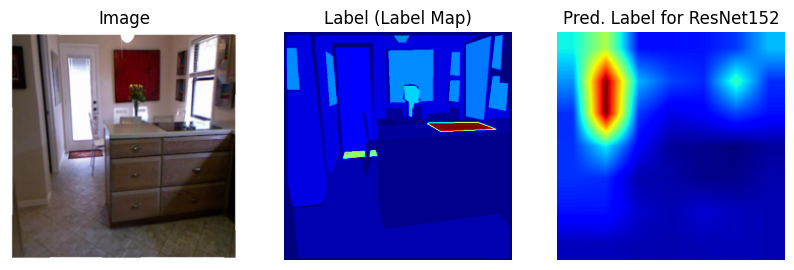

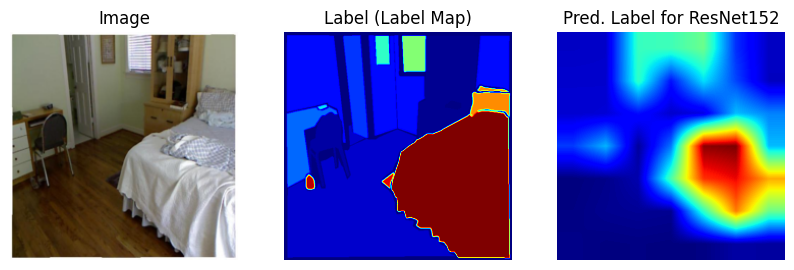

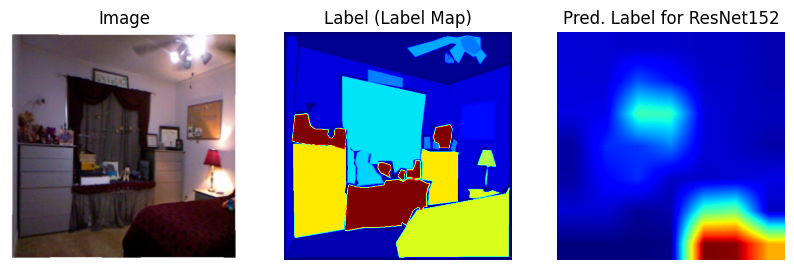

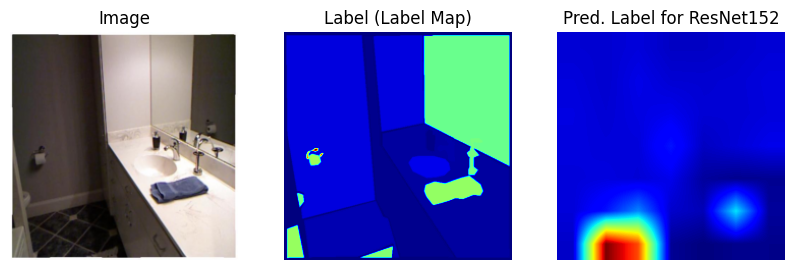

In [33]:
model_runner.test_model_label(model_resnet152, 'resnet152')
model_runner.showcase_label(model_resnet152, 'ResNet152')